
# Importing Necessary Libraries

In [1]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import random
import os

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from folium.plugins import MarkerCluster, HeatMap

from scipy.ndimage import gaussian_gradient_magnitude

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from flask_ngrok import run_with_ngrok
from flask import jsonify, request, render_template, Flask, redirect, url_for

import warnings
warnings.filterwarnings("ignore")

# Getting Dataset from NASA by using API

- https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh

In [3]:
# Read the dataset
dataframe = pd.read_csv('data/meteorite-landings.csv')
countries = pd.read_csv('data/countries_name.csv')

# Read the image
img = Image.open('data/palestine_flag.png')

### Head

In [4]:
dataframe.head()

name   id nametype     recclass      mass  fall    year    reclat  \
0    Aachen    1    Valid           L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid           H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid          EH4  107000.0  Fell  1952.0  54.21667   
3  Acapulco   10    Valid  Acapulcoite    1914.0  Fell  1976.0  16.88333   
4   Achiras  370    Valid           L6     780.0  Fell  1902.0 -33.16667   

     reclong               GeoLocation  
0    6.08333     (50.775000, 6.083330)  
1   10.23333    (56.183330, 10.233330)  
2 -113.00000  (54.216670, -113.000000)  
3  -99.90000   (16.883330, -99.900000)  
4  -64.95000  (-33.166670, -64.950000)

### Tail

In [5]:
dataframe.tail()

name     id nametype              recclass    mass   fall  \
45711  Zillah 002  31356    Valid               Eucrite   172.0  Found   
45712      Zinder  30409    Valid  Pallasite, ungrouped    46.0  Found   
45713        Zlin  30410    Valid                    H4     3.3  Found   
45714   Zubkovsky  31357    Valid                    L6  2167.0  Found   
45715  Zulu Queen  30414    Valid                  L3.7   200.0  Found   

         year    reclat    reclong               GeoLocation  
45711  1990.0  29.03700   17.01850    (29.037000, 17.018500)  
45712  1999.0  13.78333    8.96667     (13.783330, 8.966670)  
45713  1939.0  49.25000   17.66667    (49.250000, 17.666670)  
45714  2003.0  49.78917   41.50460    (49.789170, 41.504600)  
45715  1976.0  33.98333 -115.68333  (33.983330, -115.683330)

### Describe

In [6]:
dataframe.describe()

id          mass          year        reclat       reclong
count  45716.000000  4.558500e+04  45428.000000  38401.000000  38401.000000
mean   26889.735104  1.327808e+04   1991.772189    -39.122580     61.074319
std    16860.683030  5.749889e+05     27.181247     46.378511     80.647298
min        1.000000  0.000000e+00    301.000000    -87.366670   -165.433330
25%    12688.750000  7.200000e+00   1987.000000    -76.714240      0.000000
50%    24261.500000  3.260000e+01   1998.000000    -71.500000     35.666670
75%    40656.750000  2.026000e+02   2003.000000      0.000000    157.166670
max    57458.000000  6.000000e+07   2501.000000     81.166670    354.473330

In [7]:
new_column_names = {
    'name': 'City Name',
    'id': 'City ID',
    'nametype': 'Nametype',
    'recclass': 'Class',
    'mass': 'Mass',
    'fall': 'Fall',
    'year': 'Year',
    'reclat': 'Latitude',
    'reclong': 'Longitude',
    'GeoLocation': 'GeoLocation'
}
dataframe.rename(columns=new_column_names, inplace=True)

# Viewing Dataframe
dataframe

# "Valid": Indicates that the meteorite name is valid.
# Other possible values might include "Invalid" or "Unknown," which could be used if there are issues with the meteorite name.

City Name  City ID Nametype                 Class      Mass   Fall  \
0          Aachen        1    Valid                    L5      21.0   Fell   
1          Aarhus        2    Valid                    H6     720.0   Fell   
2            Abee        6    Valid                   EH4  107000.0   Fell   
3        Acapulco       10    Valid           Acapulcoite    1914.0   Fell   
4         Achiras      370    Valid                    L6     780.0   Fell   
...           ...      ...      ...                   ...       ...    ...   
45711  Zillah 002    31356    Valid               Eucrite     172.0  Found   
45712      Zinder    30409    Valid  Pallasite, ungrouped      46.0  Found   
45713        Zlin    30410    Valid                    H4       3.3  Found   
45714   Zubkovsky    31357    Valid                    L6    2167.0  Found   
45715  Zulu Queen    30414    Valid                  L3.7     200.0  Found   

         Year  Latitude  Longitude               GeoLocation  
0      1880.0  50.77500    6.08333     (50.775000, 6.083330)  
1      1951.0  56.18333   10.23333    (56.183330, 10.233330)  
2      1952.0  54.21667 -113.00000  (54.216670, -113.000000)  
3      1976.0  16.88333  -99.90000   (16.883330, -99.900000)  
4      1902.0 -33.16667  -64.95000  (-33.166670, -64.950000)  
...       ...       ...        ...                       ...  
45711  1990.0  29.03700   17.01850    (29.037000, 17.018500)  
45712  1999.0  13.78333    8.96667     (13.783330, 8.966670)  
45713  1939.0  49.25000   17.66667    (49.250000, 17.666670)  
45714  2003.0  49.78917   41.50460    (49.789170, 41.504600)  
45715  1976.0  33.98333 -115.68333  (33.983330, -115.683330)  

[45716 rows x 10 columns]

In [8]:
total_rows , total_cols = dataframe.shape
print(f"Total Rows: {total_rows}\nTotal Colums: {total_cols}")

Total Rows: 45716
Total Colums: 10


## Converting Geolocations to their respective Country

In [9]:
def conv_coord_to_location(geolocation):
    countries = []
    count = 0
    try:
        for geo in geolocation:
            coor1, coor2 = geo.replace("(", "").replace(")", "").split(",")
            url = "https://api.bigdatacloud.net/data/reverse-geocode-client?latitude=" + coor1 + "&longitude=" + coor2 + "&localityLanguage=en"
            response = requests.get(url)
            data = response.json()
            country = data['countryName']
            if country is None:
                country = "None"
            countries.append(country)
            count += 1
            print( count, country)
    except:
        return countries

    return countries

# countries = conv_coord_to_location(filter_dataframe['GeoLocation'])
# Took us 10 hours to get this result

## Useful Fuctions

In [10]:
def collect_data(df):
    dict_variable = {}

    for index, dataframe in df.iterrows():
        year = dataframe['Year']
        geolocation = dataframe['GeoLocation']
        coor1, coor2 = geolocation.replace("(", "").replace(")", "").split(",")
        geolocation = [float(coor1), float(coor2)]

        if year not in dict_variable.keys():
            dict_variable[year] = [geolocation]
        else:
            dict_variable[year].append(geolocation)

    return dict_variable

def count_variables(list_df):
    dict_variable = {}

    for i in list_df:
        if i not in dict_variable.keys():
            dict_variable[i] = 1
        else:
            dict_variable[i] += 1

    return dict_variable

def single_string(df):
  countries = list(df['Countries'])
  single_str_countries = set()

  for country in countries:
    if(isinstance(country, str)):
      single_str_countries.add(country)
  countries_txt = ' '.join(single_str_countries)

  return countries_txt

# Data Preprocessing and Filteration

In [11]:
# Filter data between 1800 and 2022
filter_dataframe = dataframe[(dataframe['Year'] > 1800) & (dataframe['Year'] < 2022)]

# Removing NaN values
filter_dataframe.dropna(axis=0, how='any', inplace = True)

# Removing 0 values
filter_dataframe = filter_dataframe.loc[(filter_dataframe != 0).all(axis=1)]

# Adding countries column to our dataframe
filter_dataframe['Countries'] = list(countries['Countries'])

# Converting Years from float to integers
filter_dataframe['Year'] = filter_dataframe['Year'].astype(int)

# Viewing shape of dataframe
total_rows , total_cols = filter_dataframe.shape
print(f"Total Rows: {total_rows}\nTotal Colums: {total_cols}")

Total Rows: 31640
Total Colums: 11


In [12]:
# Viewwing Filter Dataframe
filter_dataframe

City Name  City ID Nametype                 Class      Mass   Fall  \
0          Aachen        1    Valid                    L5      21.0   Fell   
1          Aarhus        2    Valid                    H6     720.0   Fell   
2            Abee        6    Valid                   EH4  107000.0   Fell   
3        Acapulco       10    Valid           Acapulcoite    1914.0   Fell   
4         Achiras      370    Valid                    L6     780.0   Fell   
...           ...      ...      ...                   ...       ...    ...   
45711  Zillah 002    31356    Valid               Eucrite     172.0  Found   
45712      Zinder    30409    Valid  Pallasite, ungrouped      46.0  Found   
45713        Zlin    30410    Valid                    H4       3.3  Found   
45714   Zubkovsky    31357    Valid                    L6    2167.0  Found   
45715  Zulu Queen    30414    Valid                  L3.7     200.0  Found   

       Year  Latitude  Longitude               GeoLocation  \
0      1880  50.77500    6.08333     (50.775000, 6.083330)   
1      1951  56.18333   10.23333    (56.183330, 10.233330)   
2      1952  54.21667 -113.00000  (54.216670, -113.000000)   
3      1976  16.88333  -99.90000   (16.883330, -99.900000)   
4      1902 -33.16667  -64.95000  (-33.166670, -64.950000)   
...     ...       ...        ...                       ...   
45711  1990  29.03700   17.01850    (29.037000, 17.018500)   
45712  1999  13.78333    8.96667     (13.783330, 8.966670)   
45713  1939  49.25000   17.66667    (49.250000, 17.666670)   
45714  2003  49.78917   41.50460    (49.789170, 41.504600)   
45715  1976  33.98333 -115.68333  (33.983330, -115.683330)   

                            Countries  
0                             Germany  
1                             Denmark  
2                              Canada  
3                              Mexico  
4                           Argentina  
...                               ...  
45711                           Libya  
45712                     Niger (the)  
45713                         Czechia  
45714        Russian Federation (the)  
45715  United States of America (the)  

[31640 rows x 11 columns]

### General Information

In [13]:
print("Minimum years Data: ", filter_dataframe["Year"].min())
print("Maximum years Data: ", filter_dataframe["Year"].max())
print("Average Mass of metoer(g)", int(filter_dataframe["Mass"].mean()))

Minimum years Data:  1801
Maximum years Data:  2013
Average Mass of metoer(g) 16449


# Statistical and Visual Analysis



## World Map Graph

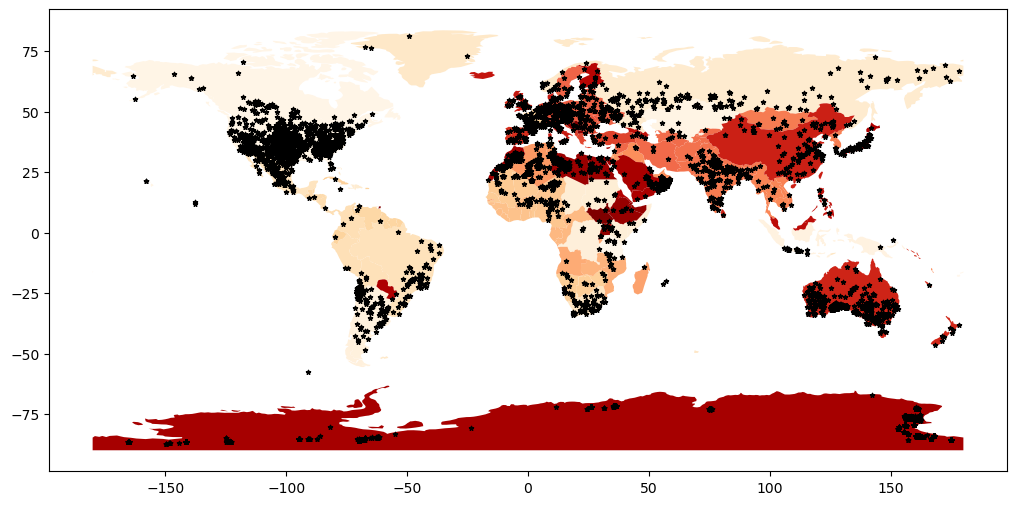

In [14]:
geometry = [Point(xy) for xy in zip(filter_dataframe['Longitude'], filter_dataframe['Latitude'])]
gdf = GeoDataFrame(filter_dataframe, geometry=geometry)

# this is a simple map that goes with geopandas
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#fig, cx = plt.subplots()
gdf.plot(ax=world_map.plot(figsize=(15, 6), cmap="OrRd"), marker='*', color='black', markersize=10);

## Treemap Chart

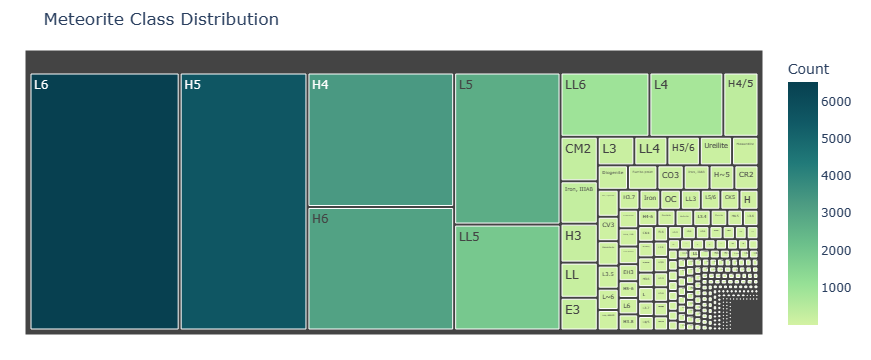

In [15]:
# Count the occurrences of each class
class_counts = filter_dataframe["Class"].value_counts()

# Create a DataFrame with 'Class' and 'Count' columns
df_classes = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})

# Create the treemap
fig = px.treemap(df_classes, path=["Class"], values='Count',
                  color='Count',  # Use the 'Count' column for coloring
                  hover_data=['Count'],
                  color_continuous_scale='Emrld',  # Use the same color scale
                  color_continuous_midpoint=np.average(df_classes['Count']),
                  range_color=[df_classes['Count'].min(), df_classes['Count'].max()]  # Adjust color range
                 )

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    title='Meteorite Class Distribution',  # Add a title if needed
    coloraxis_colorbar=dict(
        title='Count',  # Add a colorbar title if needed
        tickformat='d',  # Use 'd' for integer formatting
    )
)

fig.show()


## Whisker Box Plot

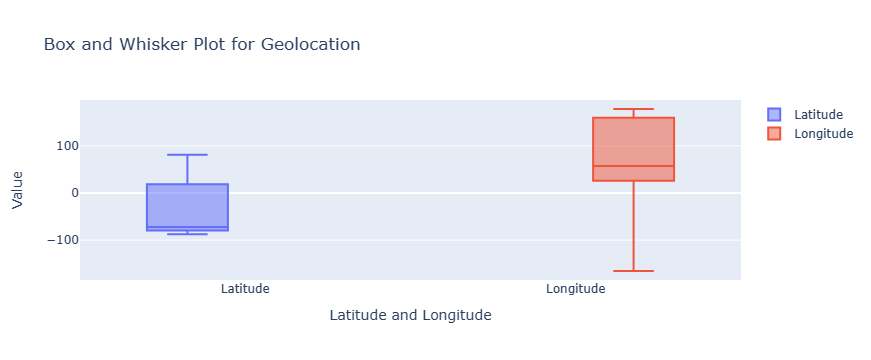

In [16]:
# Assuming df is your DataFrame and 'mass' is the column you want to plot
lat_data = filter_dataframe['Latitude']
long_data = filter_dataframe['Longitude']

# Create a figure
fig = go.Figure()

# Create box and whisker plots for 'Latitude' and 'Longitude'
fig.add_trace(go.Box(y=lat_data, name='Latitude', boxpoints=False))
fig.add_trace(go.Box(y=long_data, name='Longitude', boxpoints=False))

# Customize the layout
fig.update_layout(
    title='Box and Whisker Plot for Geolocation',
    xaxis=dict(title='Latitude and Longitude'),
    yaxis=dict(title='Value'),
    boxmode='group'
)

# Show the interactive plot
fig.show()


## WordCloud Palestine Flag Representation

(-0.5, 639.5, 399.5, -0.5)

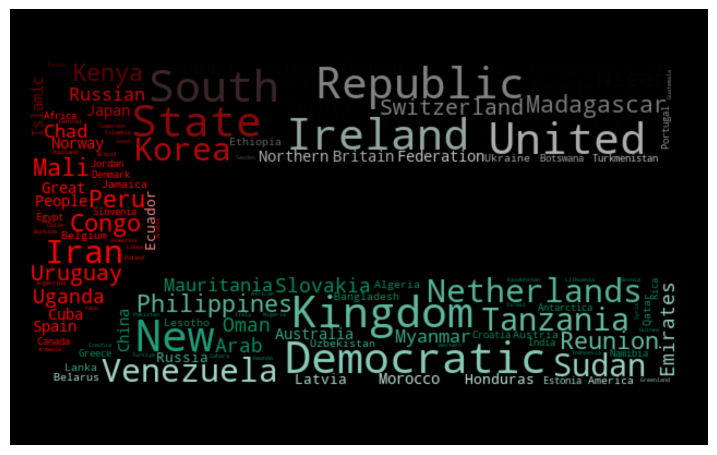

In [17]:
# load image. This has been modified in gimp to be brighter and have more saturation.
parrot_color = np.array(img)

# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
parrot_color = parrot_color[::3, ::3]

# create mask  white is "masked out"
parrot_mask = parrot_color.copy()
parrot_mask[parrot_mask.sum(axis=2) == 0] = 255

# some finesse: we enforce boundaries between colors so they get less washed out.
# For that we do some edge detection in the image
edges = np.mean([gaussian_gradient_magnitude(parrot_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
parrot_mask[edges > .08] = 255

# create wordcloud. A bit sluggish, you can subsample more strongly for quicker rendering
# relative_scaling=0 means the frequencies in the data are reflected less
# acurately but it makes a better picture
wc = WordCloud(max_words=200, mask=parrot_mask, max_font_size=40, random_state=42, relative_scaling=0, background_color="black")

# generate word cloud
wc.generate(single_string(filter_dataframe))

image_colors = ImageColorGenerator(parrot_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(9, 7))
plt.imshow(wc, interpolation="gaussian")
plt.axis("off")

## Stacked Bar Plot

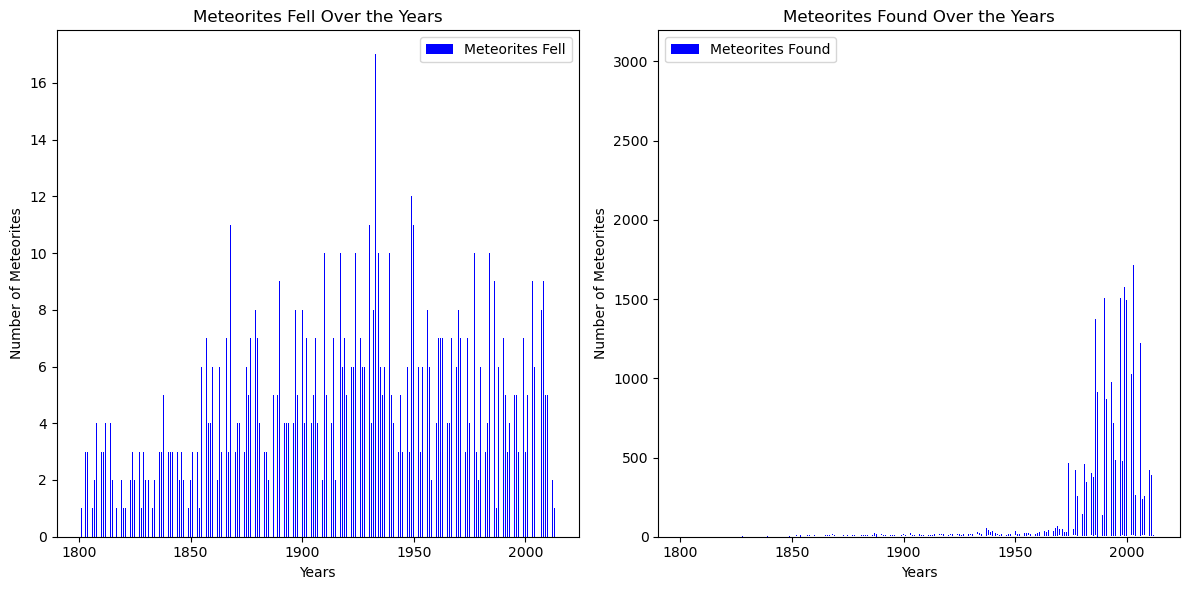

In [18]:
def stacked_bar_plot(df):
    df_fell = df[df['Fall'] == 'Fell']
    df_found = df[df['Fall'] == 'Found']
    stacked_fell = {}
    stacked_found = {}

    for i in df_fell['Year']:
        if i not in stacked_fell.keys():
            stacked_fell[i] = 1
        else:
            stacked_fell[i] += 1

    for i in df_found['Year']:
        if i not in stacked_found.keys():
            stacked_found[i] = 1
        else:
            stacked_found[i] += 1
    # Create a new dictionary to store merged data
    fell_found_dict= {}

    # Merge values for common keys
    for key in set(stacked_fell.keys()).union(stacked_found.keys()):
        values = [stacked_fell.get(key), stacked_found.get(key)]
        # Filter out None values (keys that are not present in one of the dictionaries)
        values = [value if value is not None else 0 for value in values]
        fell_found_dict[key] = values

    # print(fell_found_dict)
    years = list(fell_found_dict.keys())
    meteorites_fell = [value[0] for value in fell_found_dict.values()]
    meteorites_found = [value[1] for value in fell_found_dict.values()]

    width = 0.35  # Reduce the width to fit both bars side by side
    fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    p1 = ax.bar(years, meteorites_fell, width, label='Meteorites Fell', color='blue')
    p2 = bx.bar(years, meteorites_found, width, label='Meteorites Found', bottom=meteorites_fell, color='blue')

    ax.set_ylabel('Number of Meteorites')
    ax.set_xlabel('Years')
    ax.set_title('Meteorites Fell Over the Years')
    ax.legend()

    bx.set_ylabel('Number of Meteorites')
    bx.set_xlabel('Years')
    bx.set_title('Meteorites Found Over the Years')
    bx.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Assuming `filter_dataframe` is your DataFrame
stacked_bar_plot(filter_dataframe)

## Pie Chart for Fell and Found

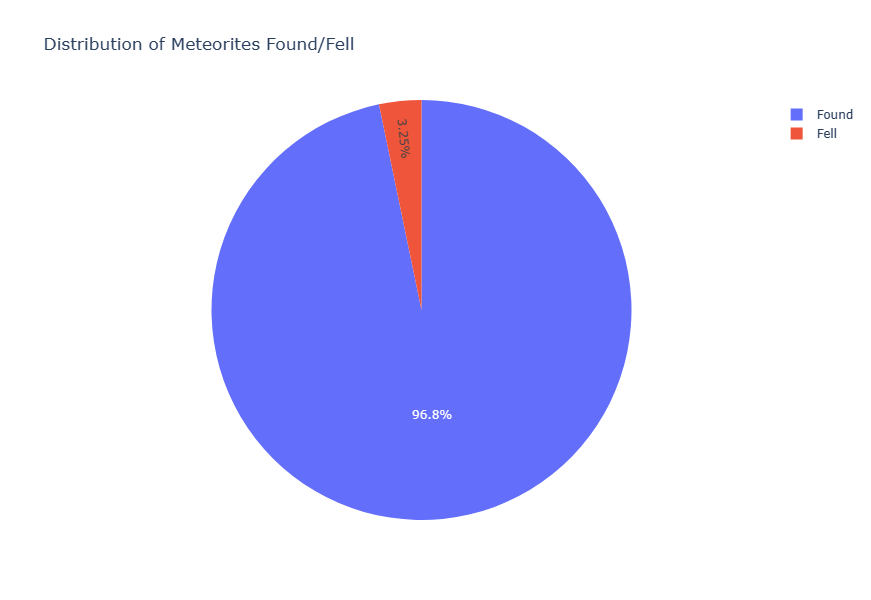

In [19]:
# Assuming 'filter_dataframe' is your DataFrame
found_fell_counts = filter_dataframe['Fall'].value_counts()

# Create a Pie chart
fig = px.pie(found_fell_counts, names=found_fell_counts.index, values=found_fell_counts.values,
             title='Distribution of Meteorites Found/Fell',
             labels={'found_fell': 'Found/Fell'},
             width=800, height=600)  # Adjust dimensions as needed

fig.show()

## Pie Chart

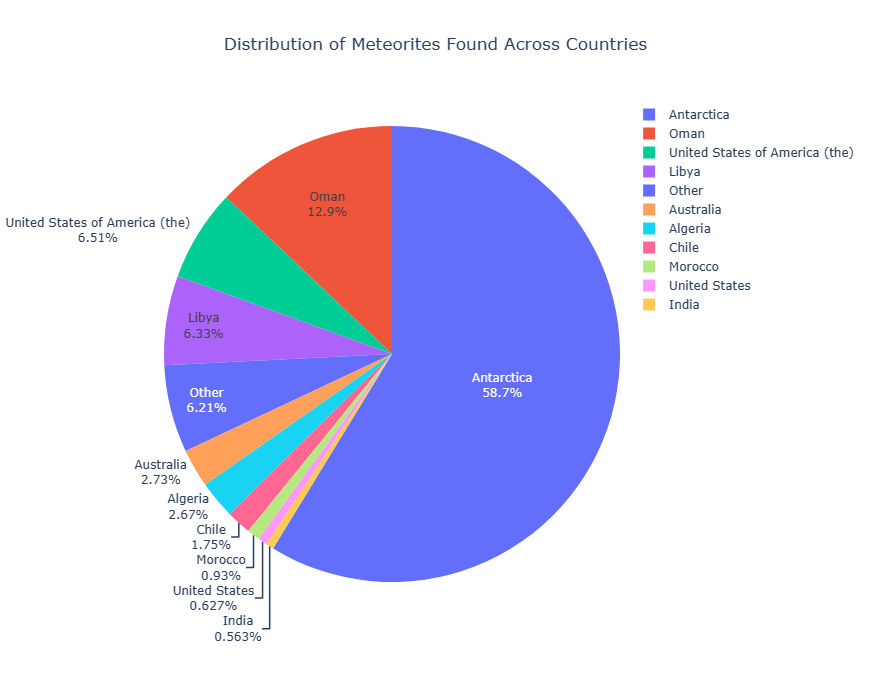

In [20]:
def plot_countries_pie_chart(df):
    countries_count = count_variables(df["Countries"].dropna())
    sorted_data = dict(sorted(countries_count.items(), key=lambda x: x[1], reverse=True))

    # Separate the top 4 and "other" countries
    top_countries = dict(list(sorted_data.items())[:10])
    other_countries_count = sum(list(sorted_data.values())[10:], start=0)
    top_countries['Other'] = other_countries_count

    # Get a qualitative color palette from Plotly Express
    color_palette = px.colors.qualitative.Plotly

    # Create a Pie chart
    fig = go.Figure(data=[go.Pie(labels=list(top_countries.keys()),
                                values=list(top_countries.values()),
                                textinfo='percent+label',
                                marker=dict(colors=color_palette))])
    fig.update_layout(title_text='Distribution of Meteorites Found Across Countries', title_x=0.5, width=1200, height=700)
    fig.show()

# Assuming `filter_dataframe` is your DataFrame
plot_countries_pie_chart(filter_dataframe)

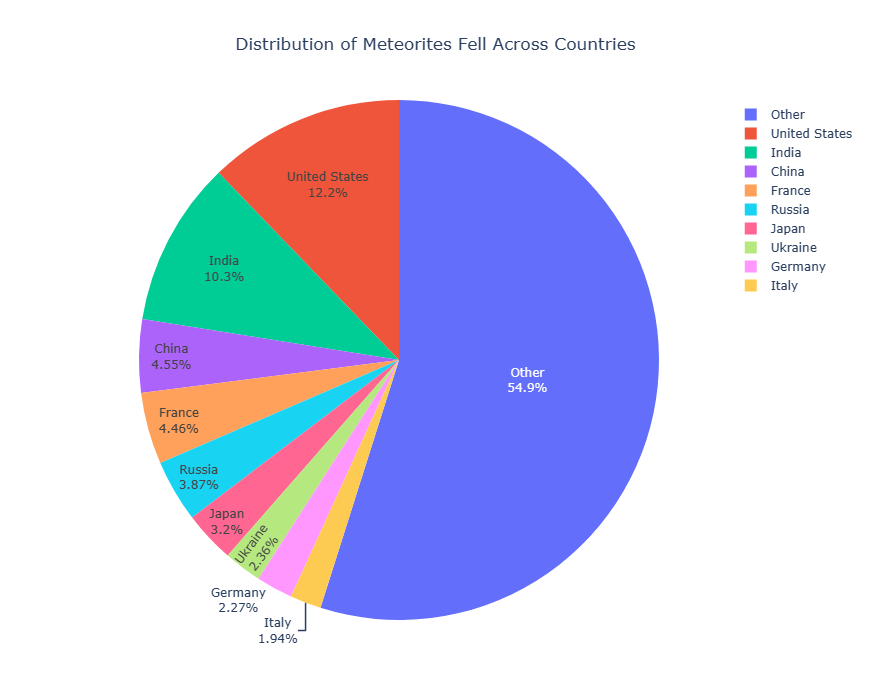

In [21]:
def plot_countries_pie_chart_seaborn(df):
    df_fell = df[df['Fall'] == 'Fell']
    countries_count = count_variables(df_fell["Countries"].dropna())
    sorted_data = dict(sorted(countries_count.items(), key=lambda x: x[1], reverse=True))

    # Separate the top 4 and "other" countries
    top_countries = dict(list(sorted_data.items())[:9])
    other_countries_count = sum(list(sorted_data.values())[4:], start=0)
    top_countries['Other'] = other_countries_count

    # Create a Pie chart
    fig = go.Figure(data=[go.Pie(labels=list(top_countries.keys()),
                                values=list(top_countries.values()),
                                textinfo='percent+label',
                                marker=dict(colors=sns.color_palette("Paired")))])

    fig.update_layout(title_text='Distribution of Meteorites Fell Across Countries', title_x=0.5, width=1200, height=700)
    fig.show()

# Assuming `filter_dataframe` is your DataFrame
plot_countries_pie_chart_seaborn(filter_dataframe)

## Histogram

Text(0.5, 1.0, "Histrogram of Meteorite's Mass")

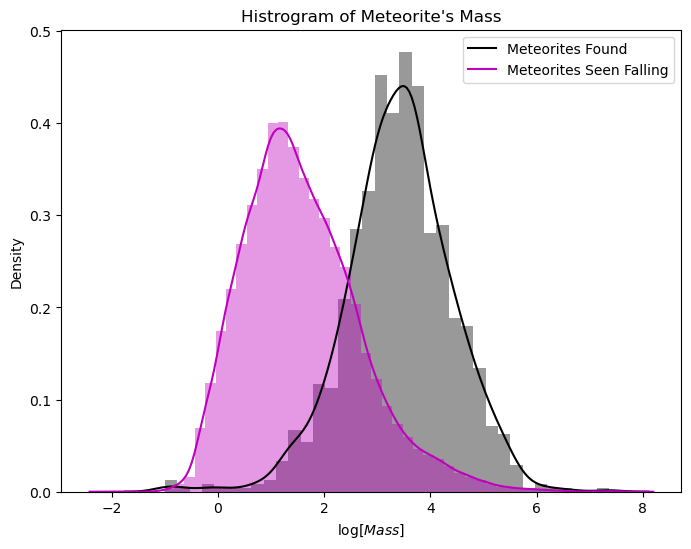

In [22]:
df = filter_dataframe.copy()
df_fell = df[df['Fall'] == 'Fell']
df_found = df[df['Fall'] == 'Found']


plt.figure(figsize=(8,6))
sns.distplot(np.log10(df_fell["Mass"]),color='k')
sns.distplot(np.log10(df_found["Mass"]),color='m',axlabel='$\log[Mass]$')
plt.legend(['Meteorites Found','Meteorites Seen Falling'])
plt.title("Histrogram of Meteorite's Mass")

# Converting Filter Dataframe, from Yearly to Monthly and also filtering out Found Data from Fall column

In [23]:
# First filtering the dataframe from 'found'
df = filter_dataframe[filter_dataframe['Fall'] == 'Fell']
df = df.sort_values(by='Year')

years = collect_data(df)

# Loop through each year in the existing data
monthly_data = {}
cont = 0

# Set random seed for reproducibility
random.seed(2)


for year, coords in years.items():
    result_list = [0] * 12
    count = 1

    if len(coords) < 12:
        for item in coords:
            index = random.randint(0, len(result_list) - 1)
            while result_list[index] != 0:
                index = random.randint(0, len(result_list) - 1)
            result_list[index] = item
    elif len(coords) > 12:
        coords = coords[:12]
        result_list = coords
    else:
        result_list = coords

    if len(coords) < 12 and cont != 0 and result_list[0] != 0:
        result_list = [0] * 12
        result_list[0] = 0
        for item in coords:
            index = random.randint(1, len(result_list) - 1)
            while result_list[index] != 0:
                index = random.randint(1, len(result_list) - 1)
            result_list[index] = item

    for i in result_list:
        key_name = str(year) + '-' + str(count)
        monthly_data[key_name] = i
        count += 1
    cont = result_list[11]

# check = 0
# for key, value in monthly_data.items():
#     print(f'Key: {key}, Value: {value}')
#     check += 1
#     if check == 12:
#         print('-----------------')
#         check = 0

# Now converting our monthly data dictionary to dataframe
monthly_dataframe = pd.DataFrame(monthly_data.items(), columns=['Year-Month', 'GeoLocation'])
# monthly_dataframe.to_csv('monthly_data.csv', index=False)

In [24]:
# Loading the new monthly dataset
monthly_dataframe.insert(loc=1, column="Year", value=monthly_dataframe["Year-Month"].apply(lambda x: int(str(x).split("-")[0])))

df# Extract Latitude and Longitude into separate columns
monthly_dataframe[['Latitude', 'Longitude']] = pd.DataFrame(monthly_dataframe['GeoLocation'].apply(lambda x: x if isinstance(x, list) else [float(0), float(0)]).tolist(), index=monthly_dataframe.index)

# Print the resulting DataFrame
monthly_dataframe

Year-Month  Year           GeoLocation  Latitude  Longitude
0        1801-1  1801         [-20.0, 57.0] -20.00000   57.00000
1        1801-2  1801                     0   0.00000    0.00000
2        1801-3  1801                     0   0.00000    0.00000
3        1801-4  1801                     0   0.00000    0.00000
4        1801-5  1801                     0   0.00000    0.00000
...         ...   ...                   ...       ...        ...
2491     2013-8  2013                     0   0.00000    0.00000
2492     2013-9  2013                     0   0.00000    0.00000
2493    2013-10  2013                     0   0.00000    0.00000
2494    2013-11  2013                     0   0.00000    0.00000
2495    2013-12  2013  [54.81667, 61.11667]  54.81667   61.11667

[2496 rows x 5 columns]

In [25]:
lat =  [i for i in monthly_dataframe['Latitude'] if i != 0]
lon = [i for i in monthly_dataframe['Longitude'] if i != 0]

## Chi Square Test

In [26]:
from scipy.stats import chi2_contingency
import scipy.stats


ct = pd.crosstab(dataframe['Class'], dataframe['Fall'])

chi2, p, dof, expected = chi2_contingency(ct)
alpha = 0.05

print("Chi-square statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
# print("Expected frequencies table:\n", expected)

# Find the critical value
critical_value = scipy.stats.chi2.ppf(1 - alpha, dof)

print("Critical value:", critical_value)

if chi2>=critical_value:
    print()
    print("According to Critical values:")
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print()
    print("According to Critical values:")
    print("Retain H0,There is no relationship between 2 categorical variables")

Chi-square statistic: 3181.030655586693
P-value: 0.0
Degrees of Freedom: 465
Critical value: 516.2723292229847

According to Critical values:
Reject H0,There is a relationship between 2 categorical variables


# Interpolation

In [27]:
dummy_dataframe = monthly_dataframe.copy()
dummy_dataframe = dummy_dataframe[dummy_dataframe.loc[:]!=0].dropna()
dummy_dataframe

Year-Month  Year             GeoLocation  Latitude  Longitude
0        1801-1  1801           [-20.0, 57.0] -20.00000   57.00000
13       1803-2  1803    [48.13333, 12.61667]  48.13333   12.61667
14       1803-3  1803     [43.86667, 5.38333]  43.86667    5.38333
17       1803-6  1803     [48.76667, 0.63333]  48.76667    0.63333
28       1804-5  1804        [49.86667, 8.65]  49.86667    8.65000
...         ...   ...                     ...       ...        ...
2467     2011-8  2011    [29.48195, -7.61123]  29.48195   -7.61123
2469    2011-10  2011   [17.17493, -11.34133]  17.17493  -11.34133
2472     2012-1  2012  [40.66813, -117.18913]  40.66813 -117.18913
2477     2012-6  2012  [38.80389, -120.90806]  38.80389 -120.90806
2495    2013-12  2013    [54.81667, 61.11667]  54.81667   61.11667

[1023 rows x 5 columns]

<Axes: xlabel='Year', ylabel='Latitude'>

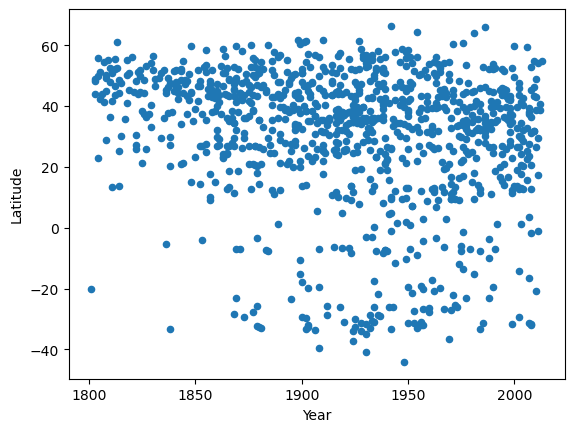

In [28]:
dummy_dataframe.plot.scatter(x="Year", y="Latitude")

<Axes: xlabel='Year', ylabel='Longitude'>

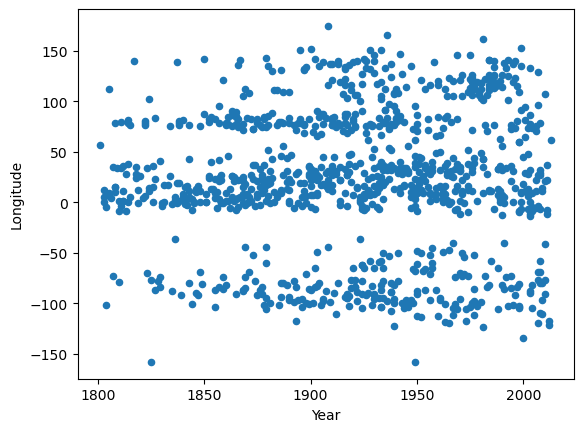

In [29]:
dummy_dataframe.plot.scatter(x="Year", y="Longitude")

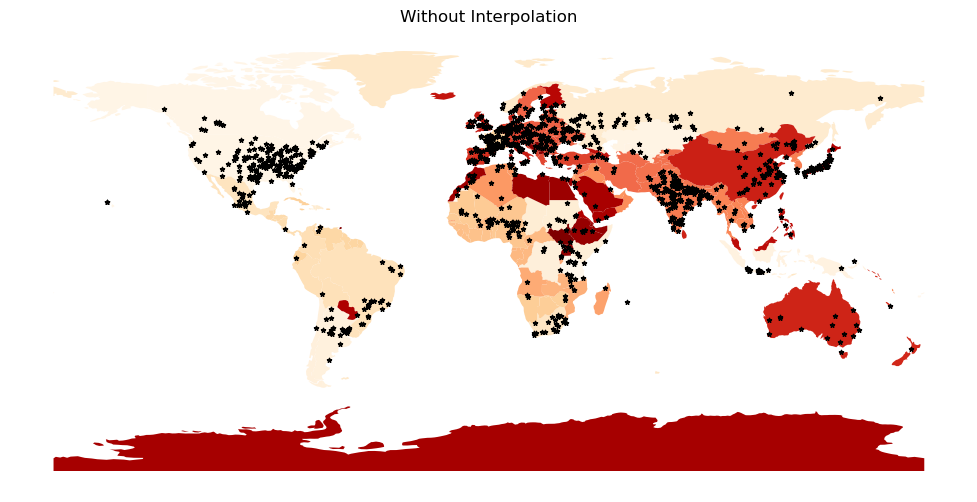

In [30]:
# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(dummy_dataframe['Longitude'], dummy_dataframe['Latitude'])]
gdf = GeoDataFrame(dummy_dataframe, geometry=geometry)

# Read the world map
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the GeoDataFrame on the world map
ax = gdf.plot(ax=world_map.plot(figsize=(15, 6), cmap="OrRd"), marker='*', color='black', markersize=10)

# Remove the axis
ax.set_axis_off()

plt.title("Without Interpolation")
# Show the plot
plt.show()

In [31]:
monthly_dataframe.replace(0, float('nan'), inplace=True)
monthly_dataframe

Year-Month  Year           GeoLocation  Latitude  Longitude
0        1801-1  1801         [-20.0, 57.0] -20.00000   57.00000
1        1801-2  1801                   NaN       NaN        NaN
2        1801-3  1801                   NaN       NaN        NaN
3        1801-4  1801                   NaN       NaN        NaN
4        1801-5  1801                   NaN       NaN        NaN
...         ...   ...                   ...       ...        ...
2491     2013-8  2013                   NaN       NaN        NaN
2492     2013-9  2013                   NaN       NaN        NaN
2493    2013-10  2013                   NaN       NaN        NaN
2494    2013-11  2013                   NaN       NaN        NaN
2495    2013-12  2013  [54.81667, 61.11667]  54.81667   61.11667

[2496 rows x 5 columns]

## Cubic Interpolation

In [32]:
columns_to_interpolate = ["Latitude", "Longitude"]

monthly_dataframe["cubic_lat"] = monthly_dataframe[columns_to_interpolate[0]].interpolate(method='cubic')
monthly_dataframe["cubic_lon"] = monthly_dataframe[columns_to_interpolate[1]].interpolate(method='cubic')
monthly_dataframe.head(14)

Year-Month  Year           GeoLocation  Latitude  Longitude   cubic_lat  \
0      1801-1  1801         [-20.0, 57.0] -20.00000   57.00000  -20.000000   
1      1801-2  1801                   NaN       NaN        NaN   25.913685   
2      1801-3  1801                   NaN       NaN        NaN   60.461987   
3      1801-4  1801                   NaN       NaN        NaN   84.895797   
4      1801-5  1801                   NaN       NaN        NaN  100.466009   
5      1801-6  1801                   NaN       NaN        NaN  108.423516   
6      1801-7  1801                   NaN       NaN        NaN  110.019211   
7      1801-8  1801                   NaN       NaN        NaN  106.503986   
8      1801-9  1801                   NaN       NaN        NaN   99.128734   
9     1801-10  1801                   NaN       NaN        NaN   89.144349   
10    1801-11  1801                   NaN       NaN        NaN   77.801723   
11    1801-12  1801                   NaN       NaN        NaN   66.351750   
12     1803-1  1803                   NaN       NaN        NaN   56.045321   
13     1803-2  1803  [48.13333, 12.61667]  48.13333   12.61667   48.133330   

     cubic_lon  
0    57.000000  
1    86.567998  
2   106.449323  
3   117.786609  
4   121.722490  
5   119.399599  
6   111.960568  
7   100.548032  
8    86.304624  
9    70.372977  
10   53.895725  
11   38.015501  
12   23.874938  
13   12.616670

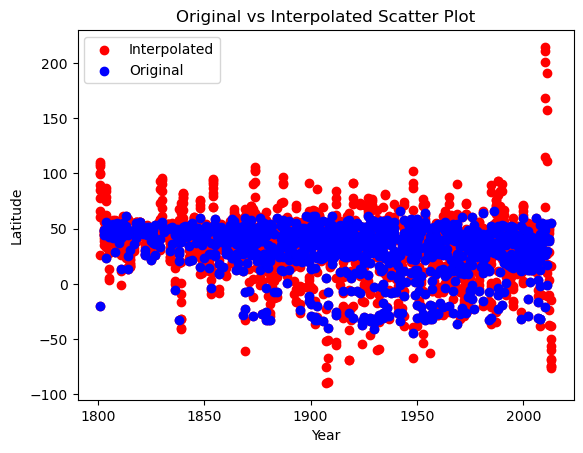

In [33]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["cubic_lat"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Latitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.legend()
plt.show()

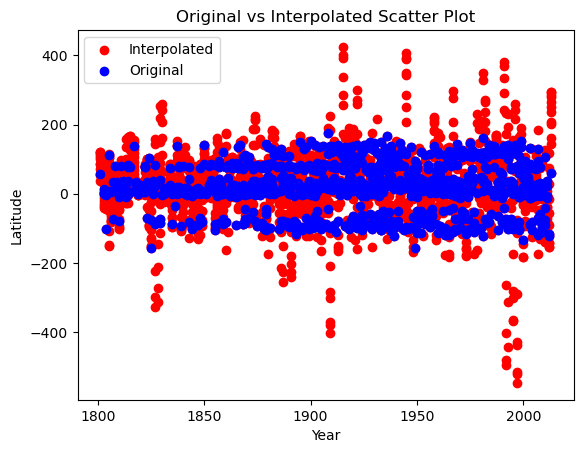

In [34]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["cubic_lon"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Longitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.legend()
plt.show()

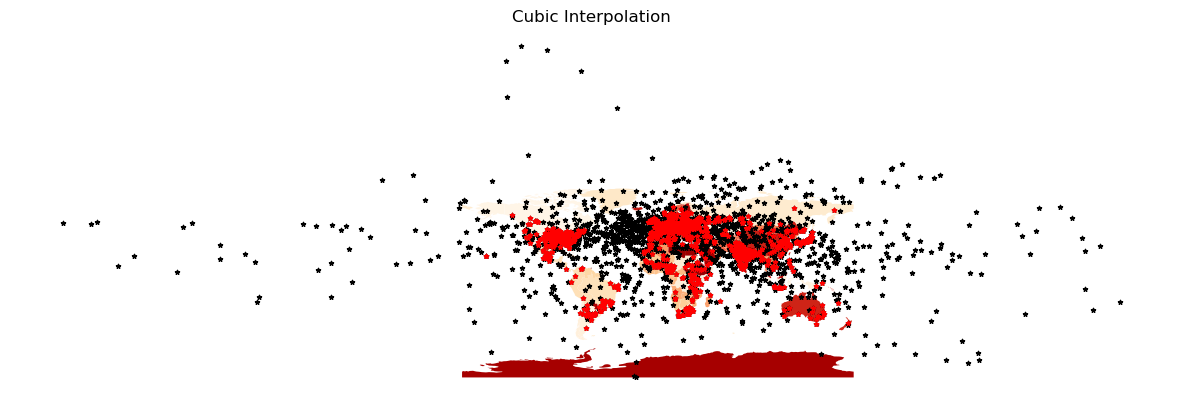

In [35]:
# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(dummy_dataframe['Longitude'], dummy_dataframe['Latitude'])]
gdf_orignal = GeoDataFrame(dummy_dataframe, geometry=geometry)


# Create a GeoDataFrame with Point geometries for interpolated coordinates
geometry_interpolated = [Point(xy) for xy in zip(monthly_dataframe['cubic_lon'], monthly_dataframe['cubic_lat'])]
gdf_interpolated = gpd.GeoDataFrame(monthly_dataframe, geometry=geometry_interpolated)


# Read the world map
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the GeoDataFrame on the world map
ax = gdf_interpolated.plot(ax=world_map.plot(figsize=(15, 6), cmap="OrRd"), marker='*', color='black', markersize=10)

gdf_orignal.plot(ax=ax, marker='*', color='red', markersize=10, label='Interpolated')

# Remove the axis
ax.set_axis_off()
plt.title("Cubic Interpolation")
# Show the plot
plt.show()

## Nearest Interpolation

In [36]:
columns_to_interpolate = ["Latitude", "Longitude"]

monthly_dataframe["nearest_lat"] = monthly_dataframe[columns_to_interpolate[0]].interpolate(method='nearest')
monthly_dataframe["nearest_lon"] = monthly_dataframe[columns_to_interpolate[1]].interpolate(method='nearest')
monthly_dataframe.head(14)

Year-Month  Year           GeoLocation  Latitude  Longitude   cubic_lat  \
0      1801-1  1801         [-20.0, 57.0] -20.00000   57.00000  -20.000000   
1      1801-2  1801                   NaN       NaN        NaN   25.913685   
2      1801-3  1801                   NaN       NaN        NaN   60.461987   
3      1801-4  1801                   NaN       NaN        NaN   84.895797   
4      1801-5  1801                   NaN       NaN        NaN  100.466009   
5      1801-6  1801                   NaN       NaN        NaN  108.423516   
6      1801-7  1801                   NaN       NaN        NaN  110.019211   
7      1801-8  1801                   NaN       NaN        NaN  106.503986   
8      1801-9  1801                   NaN       NaN        NaN   99.128734   
9     1801-10  1801                   NaN       NaN        NaN   89.144349   
10    1801-11  1801                   NaN       NaN        NaN   77.801723   
11    1801-12  1801                   NaN       NaN        NaN   66.351750   
12     1803-1  1803                   NaN       NaN        NaN   56.045321   
13     1803-2  1803  [48.13333, 12.61667]  48.13333   12.61667   48.133330   

     cubic_lon  nearest_lat  nearest_lon  
0    57.000000    -20.00000     57.00000  
1    86.567998    -20.00000     57.00000  
2   106.449323    -20.00000     57.00000  
3   117.786609    -20.00000     57.00000  
4   121.722490    -20.00000     57.00000  
5   119.399599    -20.00000     57.00000  
6   111.960568    -20.00000     57.00000  
7   100.548032     48.13333     12.61667  
8    86.304624     48.13333     12.61667  
9    70.372977     48.13333     12.61667  
10   53.895725     48.13333     12.61667  
11   38.015501     48.13333     12.61667  
12   23.874938     48.13333     12.61667  
13   12.616670     48.13333     12.61667

In [37]:
monthly_dataframe

Year-Month  Year           GeoLocation  Latitude  Longitude   cubic_lat  \
0        1801-1  1801         [-20.0, 57.0] -20.00000   57.00000  -20.000000   
1        1801-2  1801                   NaN       NaN        NaN   25.913685   
2        1801-3  1801                   NaN       NaN        NaN   60.461987   
3        1801-4  1801                   NaN       NaN        NaN   84.895797   
4        1801-5  1801                   NaN       NaN        NaN  100.466009   
...         ...   ...                   ...       ...        ...         ...   
2491     2013-8  2013                   NaN       NaN        NaN  -56.054752   
2492     2013-9  2013                   NaN       NaN        NaN  -38.494423   
2493    2013-10  2013                   NaN       NaN        NaN  -14.554287   
2494    2013-11  2013                   NaN       NaN        NaN   16.353473   
2495    2013-12  2013  [54.81667, 61.11667]  54.81667   61.11667   54.816670   

       cubic_lon  nearest_lat  nearest_lon  
0      57.000000    -20.00000     57.00000  
1      86.567998    -20.00000     57.00000  
2     106.449323    -20.00000     57.00000  
3     117.786609    -20.00000     57.00000  
4     121.722490    -20.00000     57.00000  
...          ...          ...          ...  
2491  279.996233     54.81667     61.11667  
2492  251.254800     54.81667     61.11667  
2493  206.268689     54.81667     61.11667  
2494  143.426459     54.81667     61.11667  
2495   61.116670     54.81667     61.11667  

[2496 rows x 9 columns]

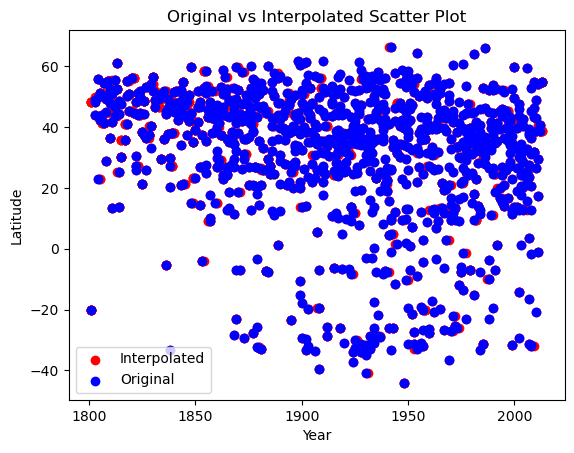

In [38]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["nearest_lat"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Latitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.legend()
plt.show()

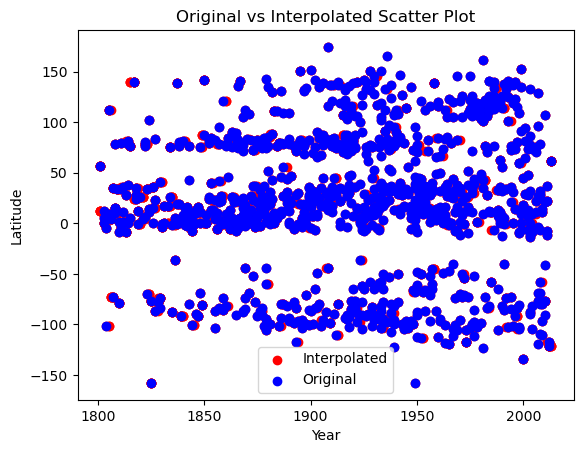

In [39]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["nearest_lon"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Longitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.legend()
plt.show()

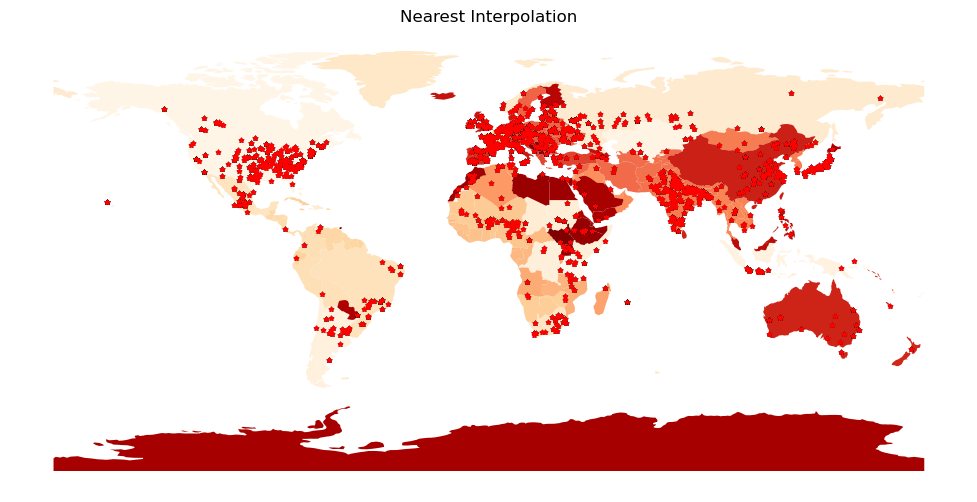

In [40]:
# Create a GeoDataFrame with Point geometries
geometry = [Point(xy) for xy in zip(dummy_dataframe['Longitude'], dummy_dataframe['Latitude'])]
gdf_orignal = GeoDataFrame(dummy_dataframe, geometry=geometry)


# Create a GeoDataFrame with Point geometries for interpolated coordinates
geometry_interpolated = [Point(xy) for xy in zip(monthly_dataframe['nearest_lon'], monthly_dataframe['nearest_lat'])]
gdf_interpolated = gpd.GeoDataFrame(monthly_dataframe, geometry=geometry_interpolated)


# Read the world map
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the GeoDataFrame on the world map
ax = gdf_interpolated.plot(ax=world_map.plot(figsize=(15, 6), cmap="OrRd"), marker='*', color='black', markersize=10)

gdf_orignal.plot(ax=ax, marker='*', color='red', markersize=10, label='Interpolated')

# Remove the axis
ax.set_axis_off()

plt.title("Nearest Interpolation")

# Show the plot
plt.show()

## Spline Interpolation

In [41]:
columns_to_interpolate = ["Latitude", "Longitude"]

# Interpolate first time
monthly_dataframe["spline_lat"] = monthly_dataframe[columns_to_interpolate[0]].interpolate(
    method='spline', order=1, s=0.)
monthly_dataframe["spline_lon"] = monthly_dataframe[columns_to_interpolate[1]].interpolate(
    method='spline', order=1, s=0.)

# Interpolate second time
monthly_dataframe["spline_lat"] = monthly_dataframe["spline_lat"].interpolate(
    method='spline', order=1, s=0.)
monthly_dataframe["spline_lon"] = monthly_dataframe["spline_lon"].interpolate(
    method='spline', order=1, s=0.)

# monthly_dataframe["spline_lat"] = monthly_dataframe["spline_lat"].interpolate(
#      method='spline', order=1, s=0.)
# monthly_dataframe["spline_lon"] = monthly_dataframe["spline_lon"].interpolate(
#      method='spline', order=1, s=0.)

# Display the first 14 rows
monthly_dataframe.head(30)

Year-Month  Year           GeoLocation  Latitude  Longitude   cubic_lat  \
0      1801-1  1801         [-20.0, 57.0] -20.00000   57.00000  -20.000000   
1      1801-2  1801                   NaN       NaN        NaN   25.913685   
2      1801-3  1801                   NaN       NaN        NaN   60.461987   
3      1801-4  1801                   NaN       NaN        NaN   84.895797   
4      1801-5  1801                   NaN       NaN        NaN  100.466009   
5      1801-6  1801                   NaN       NaN        NaN  108.423516   
6      1801-7  1801                   NaN       NaN        NaN  110.019211   
7      1801-8  1801                   NaN       NaN        NaN  106.503986   
8      1801-9  1801                   NaN       NaN        NaN   99.128734   
9     1801-10  1801                   NaN       NaN        NaN   89.144349   
10    1801-11  1801                   NaN       NaN        NaN   77.801723   
11    1801-12  1801                   NaN       NaN        NaN   66.351750   
12     1803-1  1803                   NaN       NaN        NaN   56.045321   
13     1803-2  1803  [48.13333, 12.61667]  48.13333   12.61667   48.133330   
14     1803-3  1803   [43.86667, 5.38333]  43.86667    5.38333   43.866670   
15     1803-4  1803                   NaN       NaN        NaN   43.878421   
16     1803-5  1803                   NaN       NaN        NaN   46.330415   
17     1803-6  1803   [48.76667, 0.63333]  48.76667    0.63333   48.766670   
18     1803-7  1803                   NaN       NaN        NaN   49.240409   
19     1803-8  1803                   NaN       NaN        NaN   47.841671   
20     1803-9  1803                   NaN       NaN        NaN   45.169698   
21    1803-10  1803                   NaN       NaN        NaN   41.823735   
22    1803-11  1803                   NaN       NaN        NaN   38.403024   
23    1803-12  1803                   NaN       NaN        NaN   35.506809   
24     1804-1  1804                   NaN       NaN        NaN   33.734332   
25     1804-2  1804                   NaN       NaN        NaN   33.684836   
26     1804-3  1804                   NaN       NaN        NaN   35.957565   
27     1804-4  1804                   NaN       NaN        NaN   41.151762   
28     1804-5  1804      [49.86667, 8.65]  49.86667    8.65000   49.866670   
29     1804-6  1804                   NaN       NaN        NaN   61.989732   

     cubic_lon  nearest_lat  nearest_lon  spline_lat  spline_lon  
0    57.000000    -20.00000     57.00000  -20.000000   57.000000  
1    86.567998    -20.00000     57.00000  -14.758975   53.585898  
2   106.449323    -20.00000     57.00000   -9.517949   50.171795  
3   117.786609    -20.00000     57.00000   -4.276924   46.757693  
4   121.722490    -20.00000     57.00000    0.964102   43.343591  
5   119.399599    -20.00000     57.00000    6.205127   39.929488  
6   111.960568    -20.00000     57.00000   11.446152   36.515386  
7   100.548032     48.13333     12.61667   16.687178   33.101284  
8    86.304624     48.13333     12.61667   21.928203   29.687182  
9    70.372977     48.13333     12.61667   27.169228   26.273079  
10   53.895725     48.13333     12.61667   32.410254   22.858977  
11   38.015501     48.13333     12.61667   37.651279   19.444875  
12   23.874938     48.13333     12.61667   42.892305   16.030772  
13   12.616670     48.13333     12.61667   48.133330   12.616670  
14    5.383330     43.86667      5.38333   43.866670    5.383330  
15    2.627704     43.86667      5.38333   45.500003    3.799997  
16    2.043188     48.76667      0.63333   47.133337    2.216663  
17    0.633330     48.76667      0.63333   48.766670    0.633330  
18   -3.895855     48.76667      0.63333   48.866670    1.362118  
19  -11.028486     48.76667      0.63333   48.966670    2.090906  
20  -19.546216     48.76667      0.63333   49.066670    2.819695  
21  -28.230699     48.76667      0.63333   49.166670    3.548483  
22  -35.863588     48.76667      0.63333   

In [42]:
monthly_dataframe['spline_lon'].isna().sum()

0

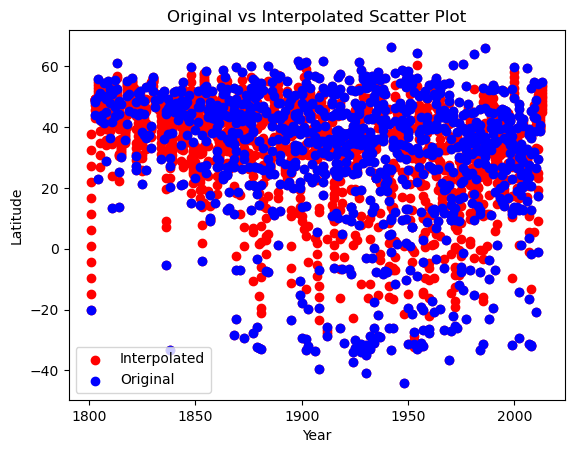

In [43]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["spline_lat"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Latitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Latitude')
plt.legend()
plt.show()

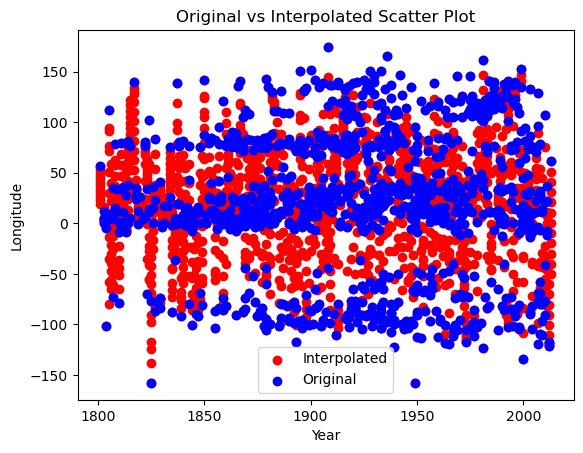

In [44]:
# Plot both "cubic_lat" and "Latitude" in a single scatter plot
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["spline_lon"], label='Interpolated', color='red')
plt.scatter(monthly_dataframe["Year"], monthly_dataframe["Longitude"], label='Original', color='blue')

# Customize the plot
plt.title('Original vs Interpolated Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Longitude')
plt.legend()
plt.show()

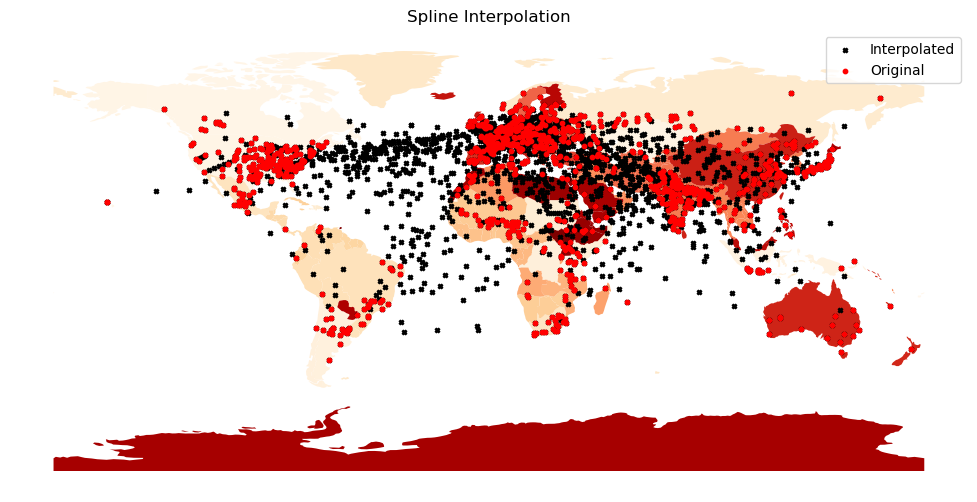

In [45]:
# Create a GeoDataFrame with Point geometries
geometry_original = [Point(xy) for xy in zip(dummy_dataframe['Longitude'], dummy_dataframe['Latitude'])]
gdf_original = gpd.GeoDataFrame(dummy_dataframe, geometry=geometry_original)

# Create a GeoDataFrame with Point geometries for interpolated coordinates
geometry_interpolated = [Point(xy) for xy in zip(monthly_dataframe['spline_lon'], monthly_dataframe['spline_lat'])]
gdf_interpolated = gpd.GeoDataFrame(monthly_dataframe, geometry=geometry_interpolated)

# Read the world map
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot both GeoDataFrames on the world map
ax = gdf_interpolated.plot(ax=world_map.plot(figsize=(15, 6), cmap="OrRd"), marker='X', color='black', markersize=10, label='Interpolated')
gdf_original.plot(ax=ax, marker='o', color='red', markersize=10, label='Original')

# Remove the axis
ax.set_axis_off()

# Show the legend
ax.legend()

plt.title("Spline Interpolation")
# Show the plot
plt.show()


# LSTM

In [46]:
new_df = pd.DataFrame({
    "Year-Month": monthly_dataframe["Year-Month"],
    "spline_lat": monthly_dataframe["spline_lat"],
    "spline_lon": monthly_dataframe["spline_lon"]
})

# Convert 'Year-Month' to timestamp
new_df['Year-Month'] = pd.to_datetime(new_df['Year-Month'])

new_df['month'] = new_df['Year-Month'].dt.month
new_df['year'] = new_df['Year-Month'].dt.year
new_df = new_df.drop('Year-Month', axis=1)

# Convert timestamp to seconds since the Unix epoch
# new_df['Year-Month'] = (new_df['Year-Month'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

new_df

spline_lat  spline_lon  month  year
0     -20.000000   57.000000      1  1801
1     -14.758975   53.585898      2  1801
2      -9.517949   50.171795      3  1801
3      -4.276924   46.757693      4  1801
4       0.964102   43.343591      5  1801
...          ...         ...    ...   ...
2491   51.258274   20.666730      8  2013
2492   52.147873   30.779215      9  2013
2493   53.037472   40.891700     10  2013
2494   53.927071   51.004185     11  2013
2495   54.816670   61.116670     12  2013

[2496 rows x 4 columns]

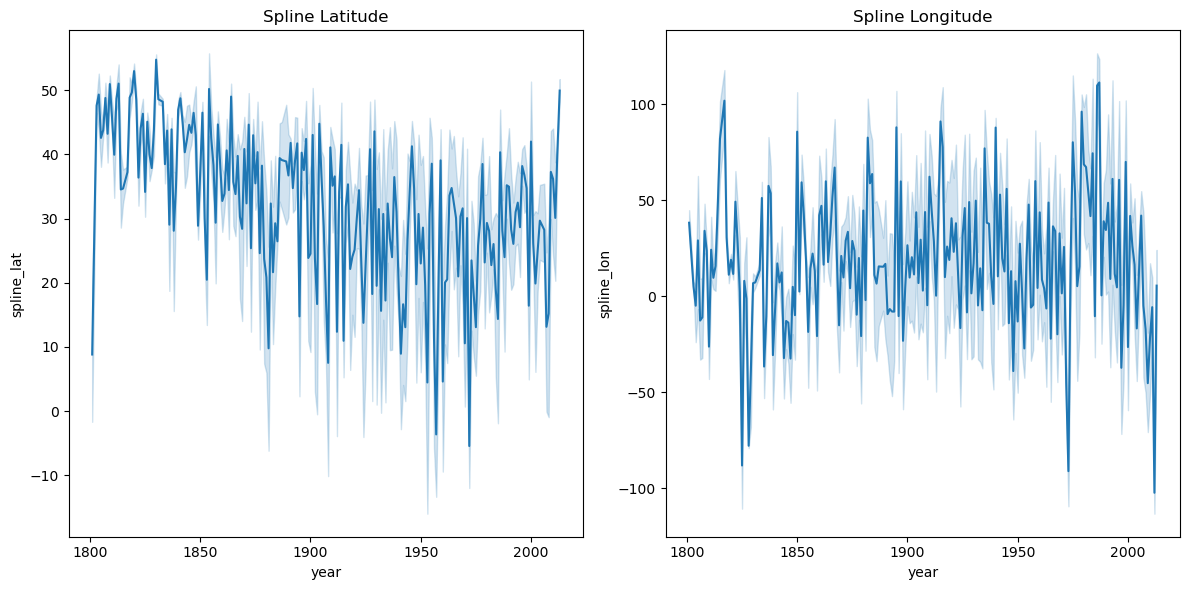

In [47]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot the first graph
sns.lineplot(y='spline_lat', x='year', data=new_df, ax=axes[0])
axes[0].set_title('Spline Latitude')

# Plot the second graph
sns.lineplot(y='spline_lon', x='year', data=new_df, ax=axes[1])
axes[1].set_title('Spline Longitude')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Lattitude LSTM Training

In [48]:
# Separate month, year, and spline_lat
month_year = new_df[['month', 'year']].values
spline_lat = new_df['spline_lat'].values

# Normalize month_year data
scaler_month_year = MinMaxScaler(feature_range=(0, 1))
month_year_scaled = scaler_month_year.fit_transform(month_year)

# Normalize spline_lat data
scaler_spline_lat = MinMaxScaler(feature_range=(0, 1))
spline_lat_scaled = scaler_spline_lat.fit_transform(spline_lat.reshape(-1, 1))

# Combine the normalized month_year and spline_lat data
data_combined_lat = np.concatenate((month_year_scaled, spline_lat_scaled), axis=1)

# Define input features and target variable
X_combined_lat, y_combined_lat = data_combined_lat[:, :-1], data_combined_lat[:, -1]

# Reshape input data for LSTM
X_combined_lat = X_combined_lat.reshape((X_combined_lat.shape[0], 1, X_combined_lat.shape[1]))

# Split the data into training and testing sets
X_train_combined_lat, X_test_combined_lat, y_train_combined_lat, y_test_combined_lat = train_test_split(X_combined_lat, y_combined_lat, test_size=0.2, random_state=42)

model_lat = Sequential()
model_lat.add(LSTM(64, activation='relu', input_shape=(X_combined_lat.shape[1], X_combined_lat.shape[2]), return_sequences=True))
model_lat.add(LSTM(32, activation='relu'))
model_lat.add(Dense(1))
model_lat.compile(optimizer=Adam(lr=0.001), loss='mse')

# Train the model
history_lat = model_lat.fit(X_train_combined_lat, y_train_combined_lat, epochs=200, batch_size=128, validation_data=(X_test_combined_lat, y_test_combined_lat), verbose=1)

Epoch 1/200



16/16 [==============================] - 5s 44ms/step - loss: 0.4871 - val_loss: 0.4581
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.4361 - val_loss: 0.4028
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.3719 - val_loss: 0.3273
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2819 - val_loss: 0.2227
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1669 - val_loss: 0.1113
Epoch 6/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0817 - val_loss: 0.0832
Epoch 7/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0714 - val_loss: 0.0763
Epoch 8/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0647 - val_loss: 0.0709
Epoch 9/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0603 - val_loss: 0.0667
Epoch 10/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0560 - val_loss: 0.0626
Epoch 11/200
16/16

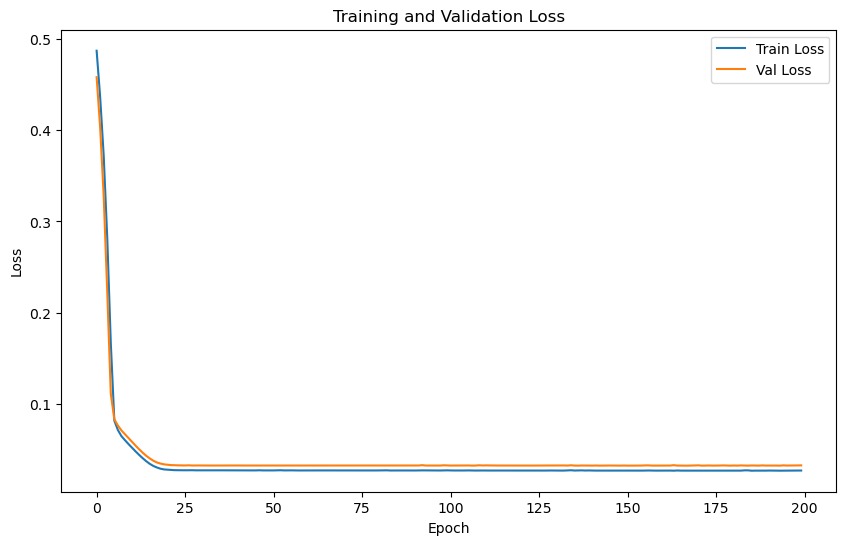

In [49]:
# Plot train loss and val loss
plt.figure(figsize=(10, 6))
plt.plot(history_lat.history['loss'], label='Train Loss')
plt.plot(history_lat.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 1s 3ms/step


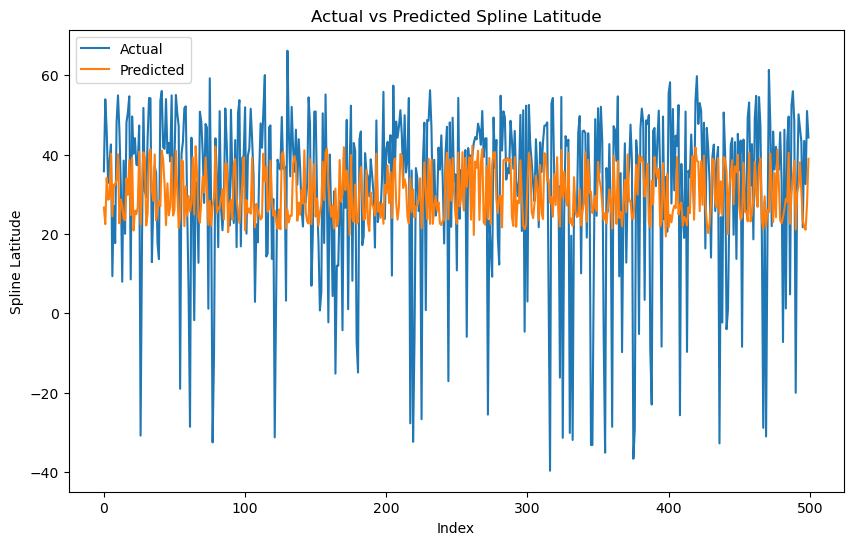

In [50]:
# Make predictions
y_lat_pred = model_lat.predict(X_test_combined_lat)

# Inverse transform the normalized predictions and actual values
y_lat_pred_inverse = scaler_spline_lat.inverse_transform(y_lat_pred.reshape(-1, 1)).flatten()
y_test_combined_inverse_lat = scaler_spline_lat.inverse_transform(y_test_combined_lat.reshape(-1, 1)).flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined_inverse_lat, label='Actual')
plt.plot(y_lat_pred_inverse, label='Predicted')
plt.title('Actual vs Predicted Spline Latitude')
plt.xlabel('Index')
plt.ylabel('Spline Latitude')
plt.legend()
plt.show()

### Longitude LSTM Training

In [51]:
# Separate month spline_lon
spline_lon = new_df['spline_lon'].values

# Normalize spline_lon data
scaler_spline_lon = MinMaxScaler(feature_range=(0, 1))
spline_lon_scaled = scaler_spline_lon.fit_transform(spline_lon.reshape(-1, 1))

# Combine the normalized month_year and spline_lon data
data_combined_lon = np.concatenate((month_year_scaled, spline_lon_scaled), axis=1)

# Define input features and target variable
X_combined_lon, y_combined_lon = data_combined_lon[:, :-1], data_combined_lon[:, -1]

# Reshape input data for LSTM
X_combined_lon = X_combined_lon.reshape((X_combined_lon.shape[0], 1, X_combined_lon.shape[1]))

# Split the data into training and testing sets
X_train_combined_lon, X_test_combined_lon, y_train_combined_lon, y_test_combined_lon = train_test_split(X_combined_lon, y_combined_lon, test_size=0.2, random_state=42)

model_lon = Sequential()
model_lon.add(LSTM(64, activation='relu', input_shape=(X_combined_lon.shape[1], X_combined_lon.shape[2]), return_sequences=True))
model_lon.add(LSTM(32, activation='relu'))
model_lon.add(Dense(1))
model_lon.compile(optimizer=Adam(lr=0.001), loss='mse')

# Train the model
history_lon = model_lon.fit(X_train_combined_lon, y_train_combined_lon, epochs=200, batch_size=128, validation_data=(X_test_combined_lon, y_test_combined_lon), verbose=1)

Epoch 1/200
16/16 [==============================] - 5s 49ms/step - loss: 0.2930 - val_loss: 0.2673
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.2401 - val_loss: 0.2051
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.1692 - val_loss: 0.1245
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0879 - val_loss: 0.0542
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0482
Epoch 6/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0443 - val_loss: 0.0439
Epoch 7/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0418 - val_loss: 0.0426
Epoch 8/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0406 - val_loss: 0.0414
Epoch 9/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0395 - val_loss: 0.0404
Epoch 10/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0385 - val_loss: 0.0394
Epoch 

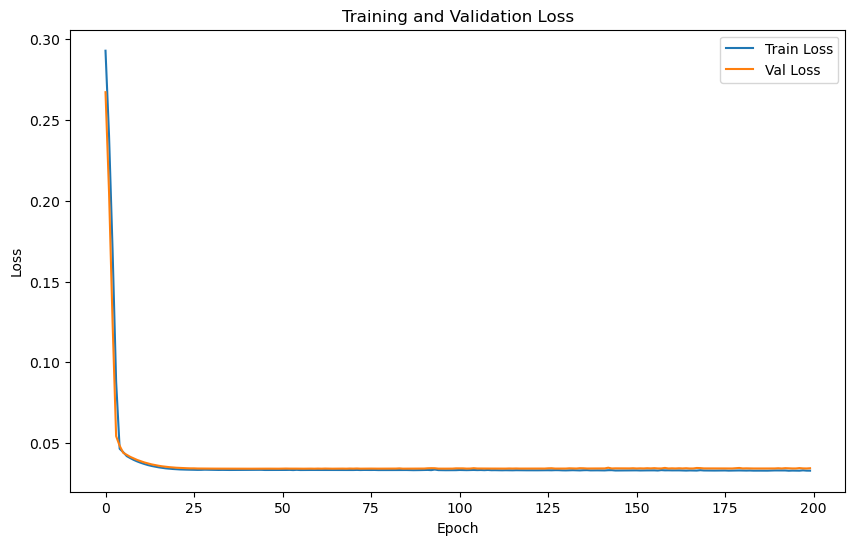

In [52]:
# Plot train loss and val loss
plt.figure(figsize=(10, 6))
plt.plot(history_lon.history['loss'], label='Train Loss')
plt.plot(history_lon.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

16/16 [==============================] - 0s 3ms/step


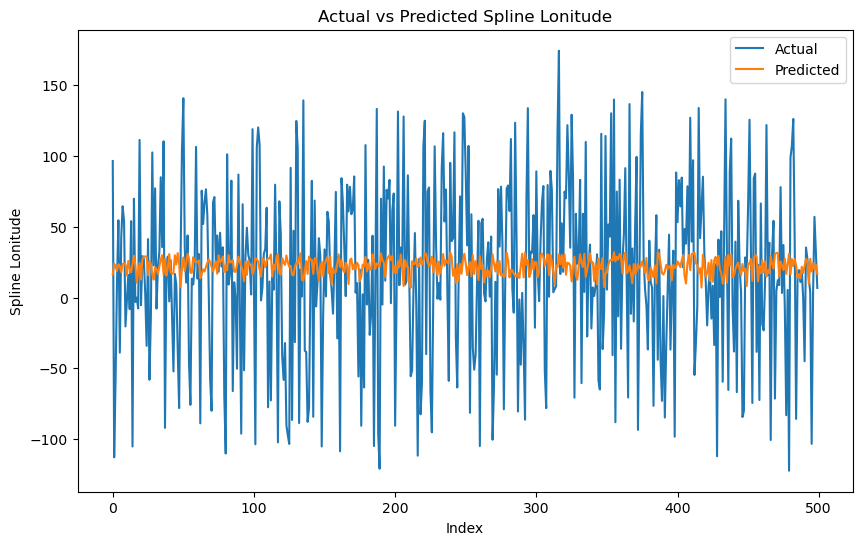

In [53]:
# Make predictions
y_lon_pred = model_lon.predict(X_test_combined_lon)

# Inverse transform the normalized predictions and actual values
y_lon_pred_inverse = scaler_spline_lon.inverse_transform(y_lon_pred.reshape(-1, 1)).flatten()
y_test_combined_inverse_lon = scaler_spline_lon.inverse_transform(y_test_combined_lon.reshape(-1, 1)).flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_combined_inverse_lon, label='Actual')
plt.plot(y_lon_pred_inverse, label='Predicted')
plt.title('Actual vs Predicted Spline Lonitude')
plt.xlabel('Index')
plt.ylabel('Spline Lonitude')
plt.legend()
plt.show()

# Machine Learning Experimentation

R2 Score:  0.39893023309207687


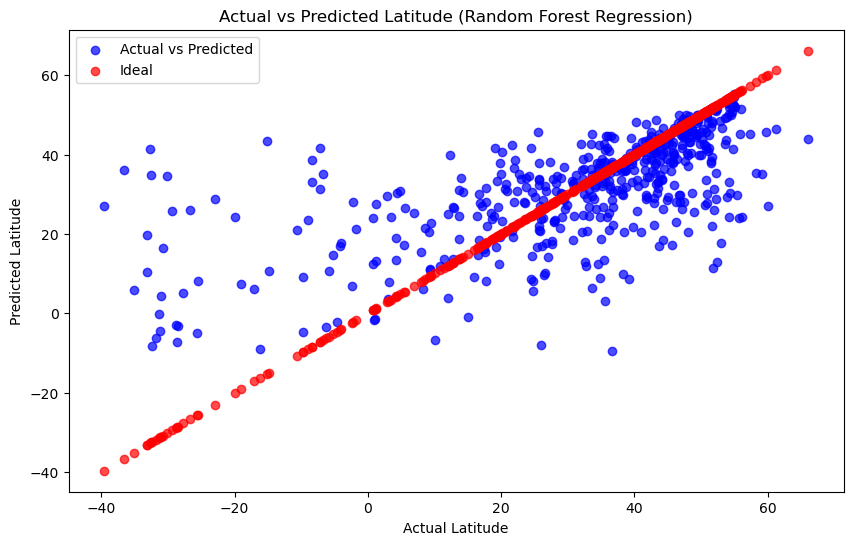

In [54]:
# Assuming 'new_df' is your DataFrame
data = new_df[['month', 'year', 'spline_lat']].values

# Define input features and target variable
X, y = data[:, :-1], data[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R2 Score: ', r2)

# Plot actual vs predicted values using scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.7, label='Actual vs Predicted')
plt.scatter(y_test, y_test, color='red', alpha=0.7, label='Ideal')
plt.title('Actual vs Predicted Latitude (Random Forest Regression)')
plt.xlabel('Actual Latitude')
plt.ylabel('Predicted Latitude')
plt.legend()
plt.show()

# Predicting Real World data from our models and Hosting it into Real World

In [55]:
file_path = os.path.join("templates", "map.html")

def predict_for_year(model, scaler_month_year, scaler_spline, year):
    # Create a new DataFrame for the specified year
    months_new_year = np.arange(1, 13)
    new_year = np.full_like(months_new_year, year)
    new_data = np.column_stack((months_new_year, new_year))

    # Normalize the year-month data
    new_data_scaled = scaler_month_year.fit_transform(new_data)

    new_shape = (12, 1, 2)
    new_data_scaled = new_data_scaled.reshape(new_shape)

    # Make predictions for the specified year
    y_pred = model.predict(new_data_scaled)

    # Inverse transform the normalized predictions
    y_pred_inverse = scaler_spline.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    return y_pred_inverse

def save_map(year):
    if os.path.exists(file_path):
        os.remove(file_path)
        print("File Removed!")


    predictions_lat = predict_for_year(model_lat, scaler_month_year, scaler_spline_lat, year)
    predictions_lon = predict_for_year(model_lon, scaler_month_year, scaler_spline_lon, year)

    predicted_geocoordinates = [(elem1, elem2) for elem1, elem2 in zip(predictions_lat, predictions_lon)]
    # print(predicted_geocoordinates)

    # Create a Folium map centered at the mean coordinates
    m1 = folium.Map(zoom_start=2,  tiles = 'OpenStreetMap')
    HeatMap(predicted_geocoordinates).add_to(m1)
    m1.save(file_path)
    print("File Saved!")

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/', methods=["GET", "POST"])
def gfg():
    if request.method == "POST":
        year = request.form.get("user_input")
        save_map(int(year))

        info = "Your year is " + year
        print(info)
        return jsonify({"redirect_url": url_for('show_map')})
    return render_template("index2.html")

@app.route('/map')
def show_map():
    print("showing map")
    return render_template('map.html')

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Awaiz\miniconda3\envs\AIforge\Lib\site-packages\urllib3\connection.py", line 200, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Awaiz\miniconda3\envs\AIforge\Lib\site-packages\urllib3\util\connection.py", line 85, in create_connection
    raise err
  File "C:\Users\Awaiz\miniconda3\envs\AIforge\Lib\site-packages\urllib3\util\connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\Awaiz\miniconda